# **1. Data pre-processing**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import matplotlib.ticker as ticker

In [30]:
# Load data
df = pd.read_csv("sports-attendance-data.csv")

# Set weekday order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["day"] = pd.Categorical(df["day"], categories=day_order, ordered=True)

# Encode teams and days as indices
df["team_idx"] = df["team"].astype("category").cat.codes
df["day_idx"]  = df["day"].astype("category").cat.codes

# Store labels
team_names = df["team"].astype("category").cat.categories
day_names  = df["day"].astype("category").cat.categories

# Split observed and missing rows
df_observed = df.dropna(subset=["attendance"]).copy()
df_missing  = df[df["attendance"].isna()].copy()

# Alias for later cells that use df_obs
df_obs = df_observed

# Arrays for modeling
attendance_obs = df_obs["attendance"].to_numpy()
team_idx_obs   = df_obs["team_idx"].to_numpy()
day_idx_obs    = df_obs["day_idx"].to_numpy()

# Basic sizes and coords for hierarchical model
n_teams = len(team_names)
n_days  = len(day_names)
coords = {"team": team_names, "day": day_names, "game": np.arange(len(df_obs))}

# Add game sequence per team for missingness plot
df["game_seq"] = df.groupby("team").cumcount() + 1

# Mark missing vs present attendance
df["Status"] = df["attendance"].apply(lambda x: "Missing Data" if pd.isna(x) else "Data Present")

# Team order for missingness plot (most missing first)
missing_counts = df[df["attendance"].isna()].groupby("team").size()
team_order_missing = (missing_counts.reindex(df["team"].unique(), fill_value=0).sort_values(ascending=False).index)

**Clearly show missing data patterns.**

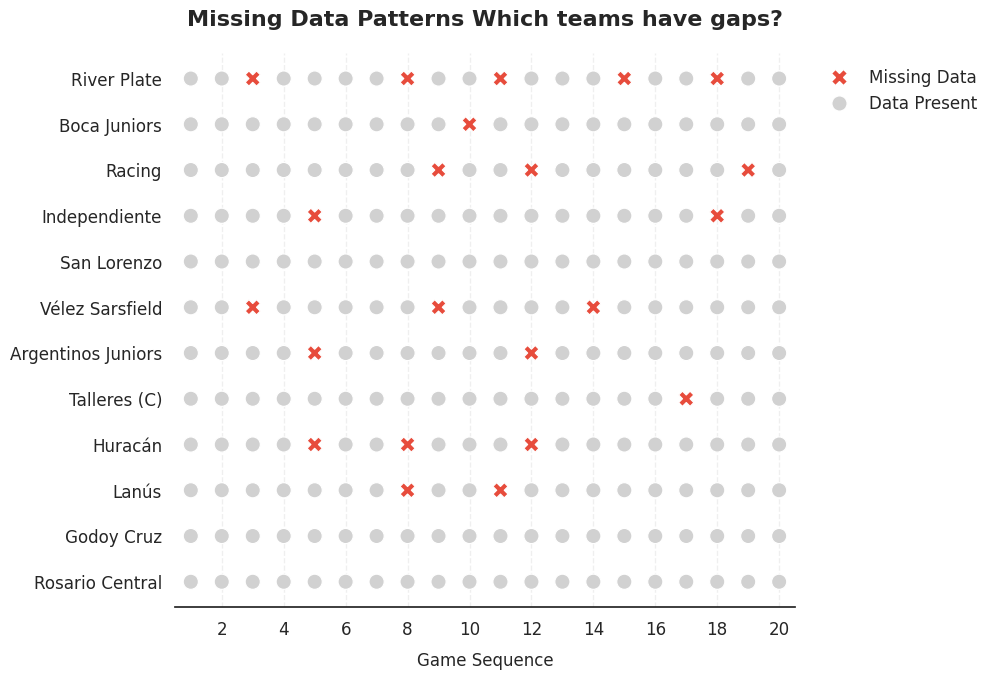

In [83]:
plt.figure(figsize=(12, 7))
sns.set_theme(style="white", font_scale=1.1)

ax = sns.scatterplot(data=df, x="game_seq", y="team", hue="Status", style="Status", markers={"Data Present": "o", "Missing Data": "X"},
    palette={"Data Present": "#d1d1d1", "Missing Data": "#e74c3c"}, s=120,hue_order=["Missing Data", "Data Present"], style_order=["Missing Data", "Data Present"])

plt.title("Missing Data Patterns Which teams have gaps?", fontsize=16, weight="bold", pad=20)
plt.xlabel("Game Sequence", fontsize=12, labelpad=10)
plt.ylabel("")

plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.xlim(0.5, df["game_seq"].max() + 0.5)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# put legend outside on the right
ax.legend(title="", bbox_to_anchor=(1.02, 1),loc="upper left",frameon=False)

sns.despine(left=True, bottom=False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


**Visualize attendance distributions by team and by day of the week.**

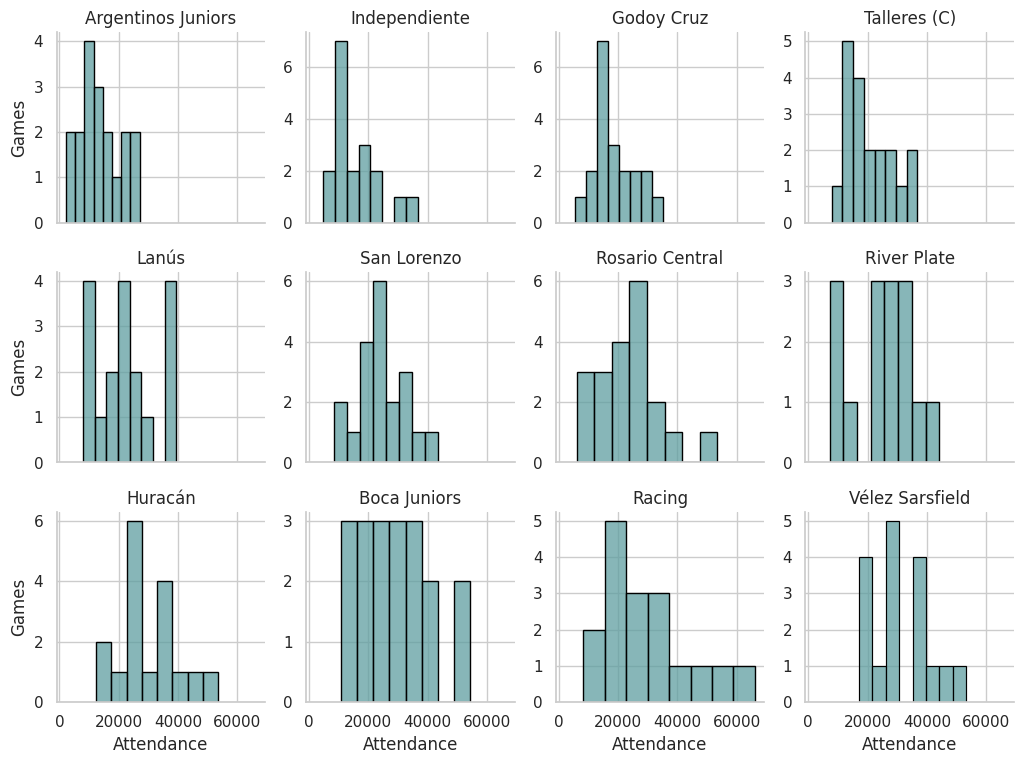

In [106]:
# Order teams by median attendance for panel order
team_order = (df_observed.groupby("team")["attendance"].median().sort_values().index)

g = sns.FacetGrid(df_observed, col="team", col_order=team_order, col_wrap=4, height=2.6, sharex=True, sharey=False)

# Plot attendance histogram per team
g.map_dataframe(sns.histplot, x="attendance", color = 'cadetblue', bins=8, edgecolor="black")
g.set_titles("{col_name}")
g.set_axis_labels("Attendance", "Games")
plt.tight_layout()
plt.show()


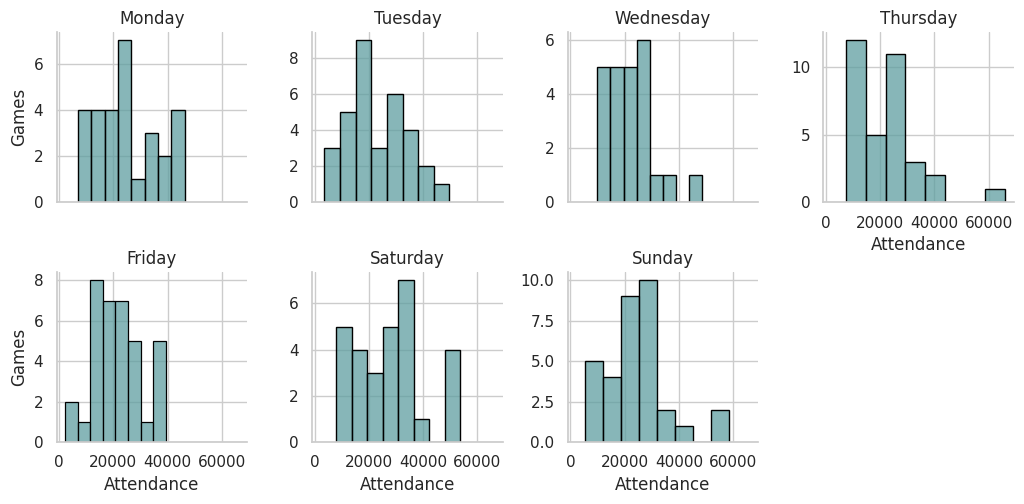

In [77]:
# Plot attendance histogram per day
g = sns.FacetGrid(f_observed, col="day", col_order=[d for d in day_order if d in df_observed["day"].unique()],col_wrap=4, height=2.6, sharex=True, sharey=False)

g.map_dataframe(sns.histplot, x="attendance", color = 'cadetblue', bins=8, edgecolor="black")
g.set_titles("{col_name}")
g.set_axis_labels("Attendance", "Games")
plt.tight_layout()
plt.show()


In [34]:
# Compare variance to mean to check overdispersion
mean_att = attendance_obs.mean()
var_att  = attendance_obs.var()

print("Sample mean:", mean_att)
print("Sample variance:", var_att)
print("Variance / mean:", var_att / mean_att)


Sample mean: 23649.981651376147
Sample variance: 128183906.77947985
Variance / mean: 5420.042546714664


# **2. Model 1: Complete pooling**

In [35]:
with pm.Model() as complete_pooling_model:

    # Shared mean attendance
    mu = pm.LogNormal("mu", mu=np.log(20000), sigma=0.4)

    # Dispersion
    alpha = pm.Exponential("alpha", lam=1/10)

    # Likelihood
    y = pm.NegativeBinomial("y", mu=mu, alpha=alpha, observed=attendance_obs)

    # Prior predictive draws
    prior_pred = pm.sample_prior_predictive(500, random_seed=1)
    y_prior = prior_pred.prior_predictive["y"].values.reshape(-1)

    # Posterior sampling
    idata_cp = pm.sample(2000, tune=2000, chains=4, target_accept=0.9, random_seed=42, idata_kwargs={"log_likelihood": True})


Output()

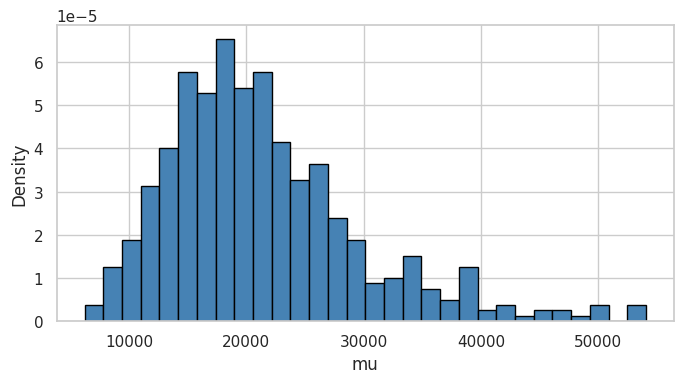

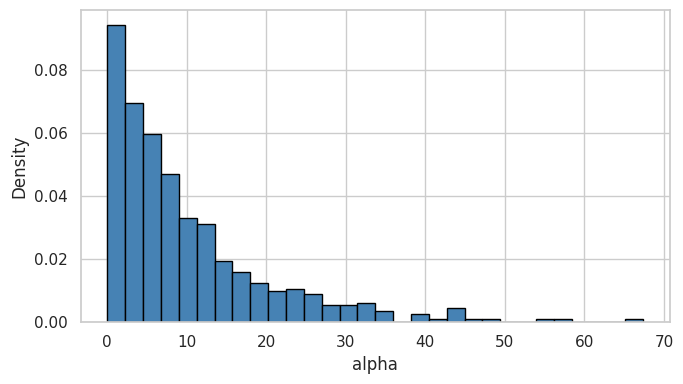

In [114]:
# Extract priors for parameters
mu_prior = prior_pred.prior["mu"].values.reshape(-1)
alpha_prior = prior_pred.prior["alpha"].values.reshape(-1)

# Plot prior for mu
plt.figure(figsize=(7,4))
plt.hist(mu_prior, bins=30, color = 'steelblue', edgecolor="black", density=True)
plt.xlabel("mu")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# Plot prior for alpha
plt.figure(figsize=(7,4))
plt.hist(alpha_prior, bins=30, color = 'steelblue', edgecolor="black", density=True)
plt.xlabel("alpha")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


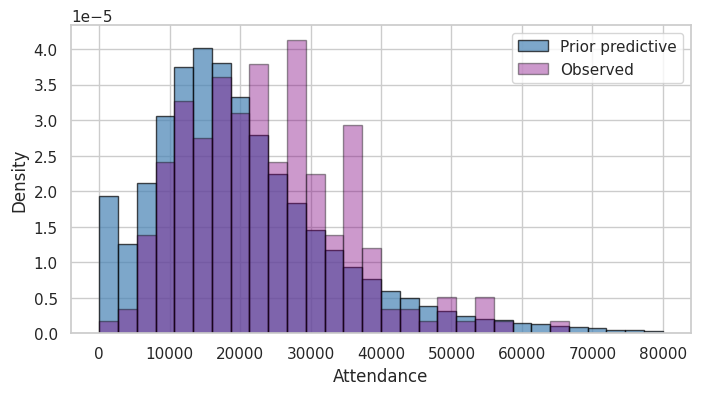

In [115]:
# Compare prior predictive to observed attendance
bins = np.linspace(0, 80000, 31)

plt.figure(figsize=(8,4))
plt.hist(y_prior, bins=bins, density=True, alpha=0.7, color = 'steelblue', edgecolor="black", label="Prior predictive")
plt.hist(attendance_obs, bins=bins, density=True, alpha=0.4, color = 'purple', edgecolor="black", label="Observed")

plt.xlabel("Attendance")
plt.ylabel("Density")
plt.legend()
plt.show()


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,23649.932,799.574,22096.092,25113.774,9.482,9.482,7141.0,4830.0,1.0
alpha,4.071,0.375,3.373,4.779,0.004,0.004,7954.0,5453.0,1.0


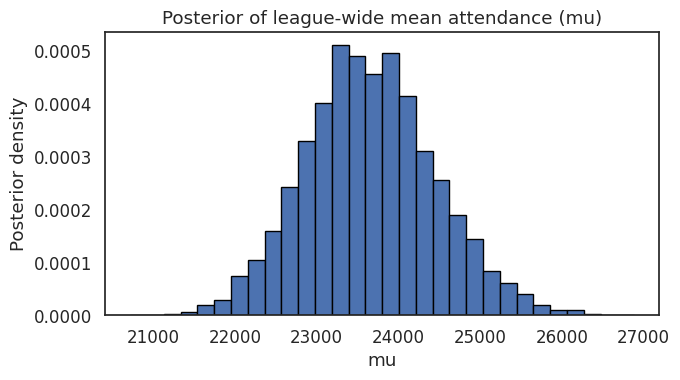

Posterior mean mu: 23649.93173726931
94% HDI for mu: [22096.09166969 25113.77427478]


In [38]:
# Posterior summary for mu and alpha
display(az.summary(idata_cp, var_names=["mu", "alpha"]))

# Plot posterior for mu
posterior_mu = idata_cp.posterior["mu"].values.ravel()

plt.figure(figsize=(7,4))
plt.hist(posterior_mu, bins=30, edgecolor="black", density=True)
plt.title("Posterior of league-wide mean attendance (mu)")
plt.xlabel("mu")
plt.ylabel("Posterior density")
plt.tight_layout()
plt.show()

# 94% HDI for mu
hdi_mu = az.hdi(posterior_mu, hdi_prob=0.94)
print("Posterior mean mu:", posterior_mu.mean())
print("94% HDI for mu:", hdi_mu)


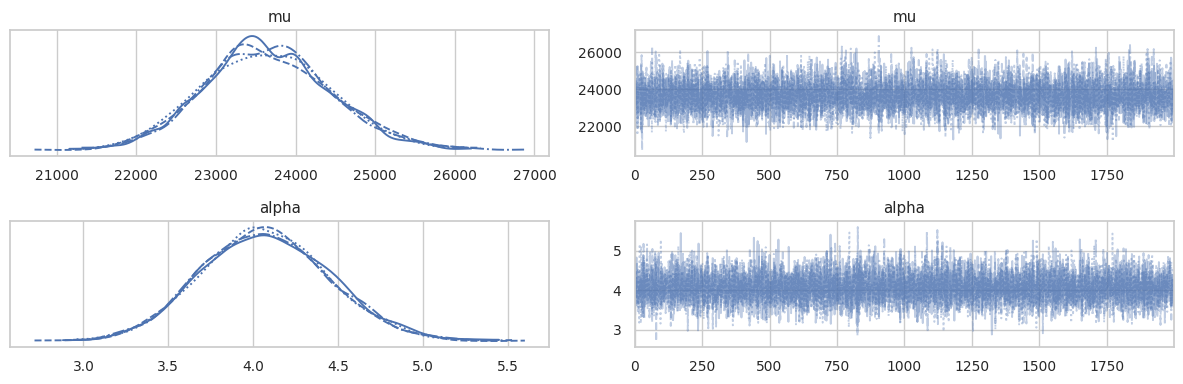

Output()

<Figure size 1000x600 with 0 Axes>

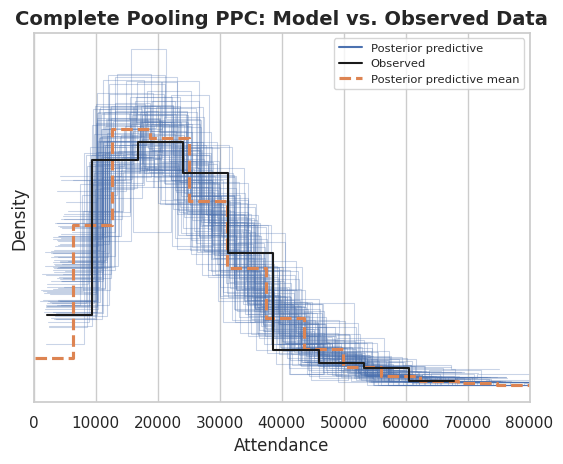

In [116]:
# Trace plots
az.plot_trace(idata_cp, var_names=["mu", "alpha"])
plt.tight_layout()
plt.show()

# Posterior predictive draws
with complete_pooling_model:
    ppc_cp = pm.sample_posterior_predictive(idata_cp, random_seed=123, extend_inferencedata=True)

# PPC plot
plt.figure(figsize=(10, 6))
az.plot_ppc(ppc_cp, num_pp_samples=100, alpha=0.3)
plt.title("Complete Pooling PPC: Model vs. Observed Data", fontsize=14, weight="bold")
plt.xlabel("Attendance")
plt.ylabel("Density")
plt.xlim(0, 80000)
plt.show()


# **3. Model 2: Hierarchical model (partial pooling)**

In [40]:
with pm.Model(coords=coords) as hierarchical_model:

    # Data containers
    team_idx_data = pm.Data("team_idx", team_idx_obs, dims="game")
    day_idx_data  = pm.Data("day_idx",  day_idx_obs,  dims="game")

    # Global baseline
    alpha0 = pm.Normal("alpha0", mu=np.log(20000), sigma=0.5)

    # Team effects (non-centered)
    sigma_team = pm.Exponential("sigma_team", lam=1.0)
    beta_team_raw = pm.Normal("beta_team_raw", mu=0, sigma=1, dims="team")
    beta_team = pm.Deterministic("beta_team", beta_team_raw * sigma_team, dims="team")

    # Day effects (non-centered)
    sigma_day = pm.Exponential("sigma_day", lam=1.0)
    gamma_day_raw = pm.Normal("gamma_day_raw", mu=0, sigma=1, dims="day")
    gamma_day = pm.Deterministic("gamma_day", gamma_day_raw * sigma_day, dims="day")

    # Expected log mean
    log_mu_ij = alpha0 + beta_team[team_idx_data] + gamma_day[day_idx_data]
    mu_ij = pm.Deterministic("mu_ij", pm.math.exp(log_mu_ij), dims="game")

    # Dispersion
    alpha_disp = pm.Exponential("alpha_disp", lam=1/10)

    # Likelihood
    y = pm.NegativeBinomial("y", mu=mu_ij, alpha=alpha_disp, observed=attendance_obs, dims="game")

    # Posterior sampling
    idata_h = pm.sample(draws=2000, tune=2000, chains=4, target_accept=0.95, random_seed=42, idata_kwargs={"log_likelihood": True})

display(az.summary(idata_h, var_names=["sigma_team", "sigma_day", "alpha_disp", "alpha0"]))


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_team,0.267,0.078,0.135,0.405,0.002,0.002,2169.0,3036.0,1.0
sigma_day,0.054,0.044,0.000,0.130,0.001,0.001,3228.0,3211.0,1.0
alpha_disp,4.990,0.481,4.070,5.867,0.006,0.005,6923.0,5064.0,1.0
alpha0,10.043,0.086,9.887,10.211,0.002,0.001,2198.0,3543.0,1.0


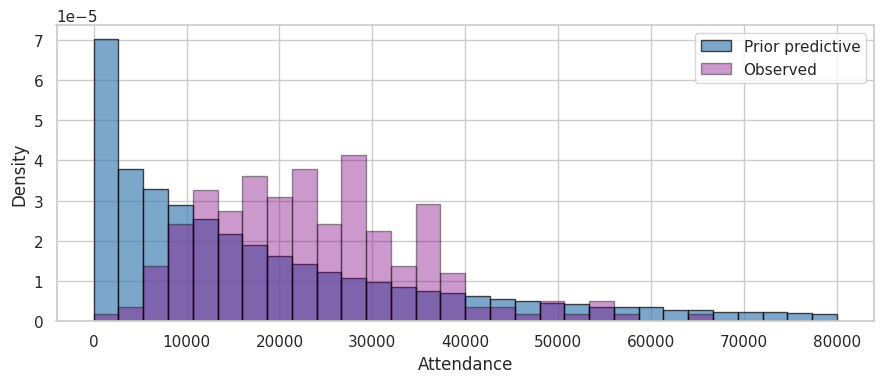

In [117]:
# Prior predictive draws for hierarchical model
with hierarchical_model:
    prior_pred_h = pm.sample_prior_predictive(samples=500, random_seed=1)

y_prior_h = prior_pred_h.prior_predictive["y"].values.reshape(-1)

bins = np.linspace(0, 80000, 31)

plt.figure(figsize=(9,4))
plt.hist(y_prior_h, bins=bins, density=True, color = 'steelblue', alpha=0.7, edgecolor="black", label="Prior predictive")
plt.hist(attendance_obs, bins=bins, density=True, color = 'purple', alpha=0.4, edgecolor="black", label="Observed")

plt.xlabel("Attendance")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
def pairplot_divergences_idata(idata, var1, var2, figsize=(5,5)):
    # Pull posterior draws
    x = idata.posterior[var1].values.reshape(-1)
    y = idata.posterior[var2].values.reshape(-1)

    # Divergence flags
    div = idata.sample_stats["diverging"].values.reshape(-1)

    plt.figure(figsize=figsize)

    # Non-divergent draws
    plt.scatter(x[~div], y[~div], s=8, alpha=0.25, color="black", label="samples")

    # Divergent draws
    if div.any():
        plt.scatter(x[div], y[div], s=18, alpha=0.9, color="red", label="divergences")

    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f"samples and divergences ({var1} vs {var2})")
    plt.legend()
    plt.show()


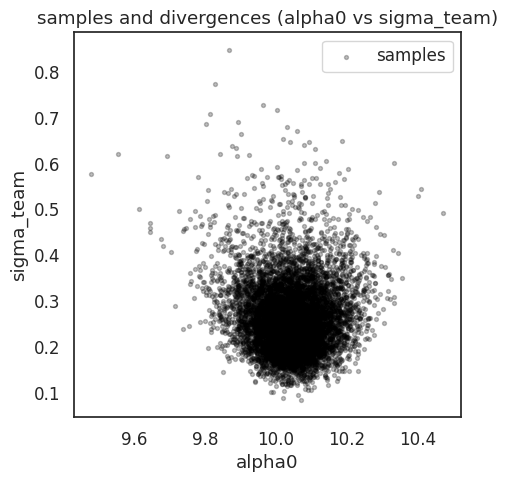

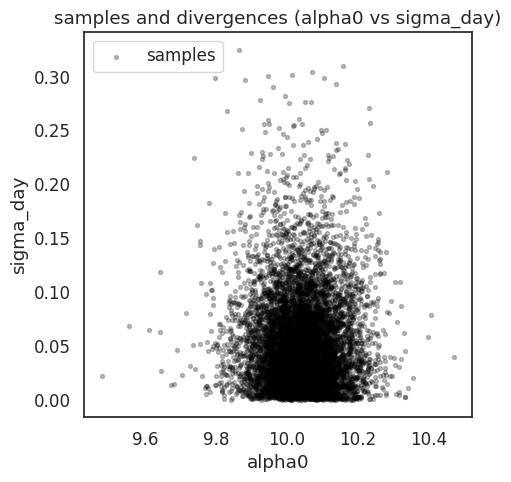

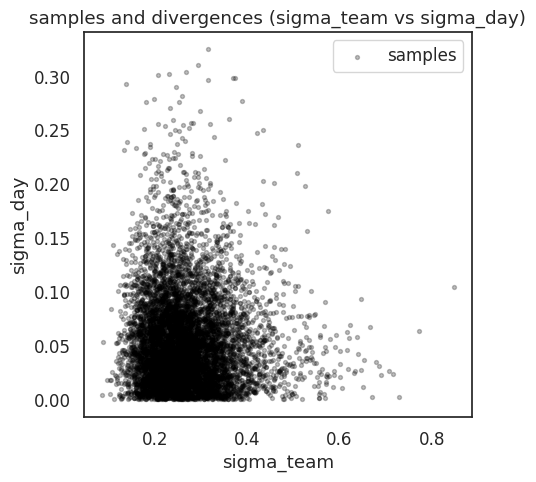

In [43]:
# Pairplots to inspect funnels and divergences
pairplot_divergences_idata(idata_h, "alpha0", "sigma_team")
pairplot_divergences_idata(idata_h, "alpha0", "sigma_day")
pairplot_divergences_idata(idata_h, "sigma_team", "sigma_day")


In [44]:
#CODE FROM CLASS!!

# You don't have to read through this function. Its purpose is to produce
# a contour plot of a 2-dimensional slice through a high-dimensional
# distribution. This function handles the messy details needed to produce
# the various contour plots in this workbook.

def plot_two_parameter_log_posterior(model, variable_params, fixed_params=None,
                                     plot_kind='contour', contour_kwargs=None,
                                     threed_kwargs=None):
    '''
    Inputs:

        model (pymc.Model) The model for which to produce a contour plot.

        variable_params (list of [str, array]) The two variables for which
          to produce the contour plot. These must be two variables listed
          in `model.value_vars`. Variable names can contain indices, for example
          "theta[1]" will plot the second entry in the theta parameter array.
          Provide the string name and a NumPy array of values for each variable.

        fixed_params (dict) This dictionary maps from each of the remaining
          variables in the model (not in `variable_params`) to fixed values.
          The contour plot will keep the values of these variables fixed and
          vary the values of the variables in `variable_params`. The dict maps
          from variable names to their values. Array variables must map to
          an array of values of the correct length. Scalar variables must map
          to scalar values.

        plot_kind (str) This is "contour", "3d", or "both", indicating which
          type of plot to produce.

        contour_kwargs (dict) Keyword arguments to pass on to the contour
          plotting function.

        threed_kwargs (dict) Keyword arguments to pass on to the 3d plotting
          function.
    '''
    if plot_kind not in ['contour', '3d', 'both']:
        raise ValueError("plot_kind must be 'contour' or '3d' or 'both'")

    # Check if any of the variable parameters contain indexes and parse them
    var_names = []
    var_indexes = []
    var_ranges = []
    for var_name, var_range in variable_params:
        if var_name.endswith(']'):
            pos = var_name.find('[')
            assert pos != -1
            var_index = int(var_name[pos+1:-1])
            var_name = var_name[:pos]
        else:
            var_index = None
        var_names.append(var_name)
        var_indexes.append(var_index)
        var_ranges.append(var_range)

    # Set up the log posterior density function and array of values for the
    # contour/3d plot.
    logp = model.compile_logp()
    log_prob_values = np.empty((len(var_ranges[1]), len(var_ranges[0])))
    point = dict(fixed_params or {})
    for i, var1_value in enumerate(var_ranges[0]):
        if var_indexes[0] is not None:
            point[var_names[0]][var_indexes[0]] = var1_value
        else:
            point[var_names[0]] = var1_value
        for j, var2_value in enumerate(var_ranges[1]):
            if var_indexes[1] is not None:
                point[var_names[1]][var_indexes[1]] = var2_value
            else:
                point[var_names[1]] = var2_value
            log_prob_values[j, i] = logp(point)

    if plot_kind in ('contour', 'both'):
        # Make a contour plot
        plt.figure(figsize=(7, 6))
        plt.title(f'Contour plot of unnormalized log posterior density')
        plt.contour(var_ranges[0], var_ranges[1], log_prob_values, **(contour_kwargs or {}))
        plt.colorbar()
        plt.xlabel(variable_params[0][0])
        plt.ylabel(variable_params[1][0])

    if plot_kind in ('3d', 'both'):
        # Make a 3d plot
        from matplotlib import cm
        fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": "3d"})
        plt.title(f'3d plot of unnormalized log posterior density')
        surf = ax.plot_surface(
            *np.meshgrid(var_ranges[0], var_ranges[1]), log_prob_values,
            cmap=cm.viridis, **(threed_kwargs or {}))
        plt.xlabel(variable_params[0][0])
        plt.ylabel(variable_params[1][0])

Output()

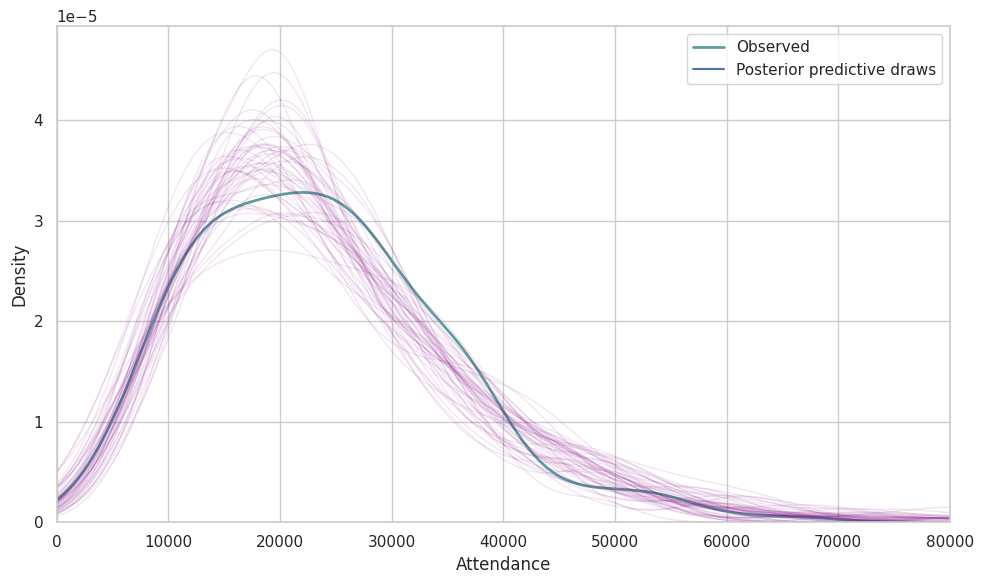

In [118]:
# Posterior predictive draws for hierarchical model
with hierarchical_model:
    ppc_h = pm.sample_posterior_predictive(idata_h, random_seed=42, extend_inferencedata=True)

y_pred = ppc_h.posterior_predictive["y"].values
flat_preds = y_pred.reshape(-1, y_pred.shape[-1])

plt.figure(figsize=(10, 6))

# Observed density
sns.kdeplot(attendance_obs, color="cadetblue", label="Observed", linewidth=2)

# Predicted densities
idx = np.random.choice(len(flat_preds), 50, replace=False)
for i in idx:
    sns.kdeplot(flat_preds[i], color = 'purple', alpha=0.1, linewidth=1)

plt.plot([], [], label="Posterior predictive draws")

plt.xlabel("Attendance")
plt.ylabel("Density")
plt.xlim(0, 80000)
plt.legend()
plt.tight_layout()
plt.show()


Output()

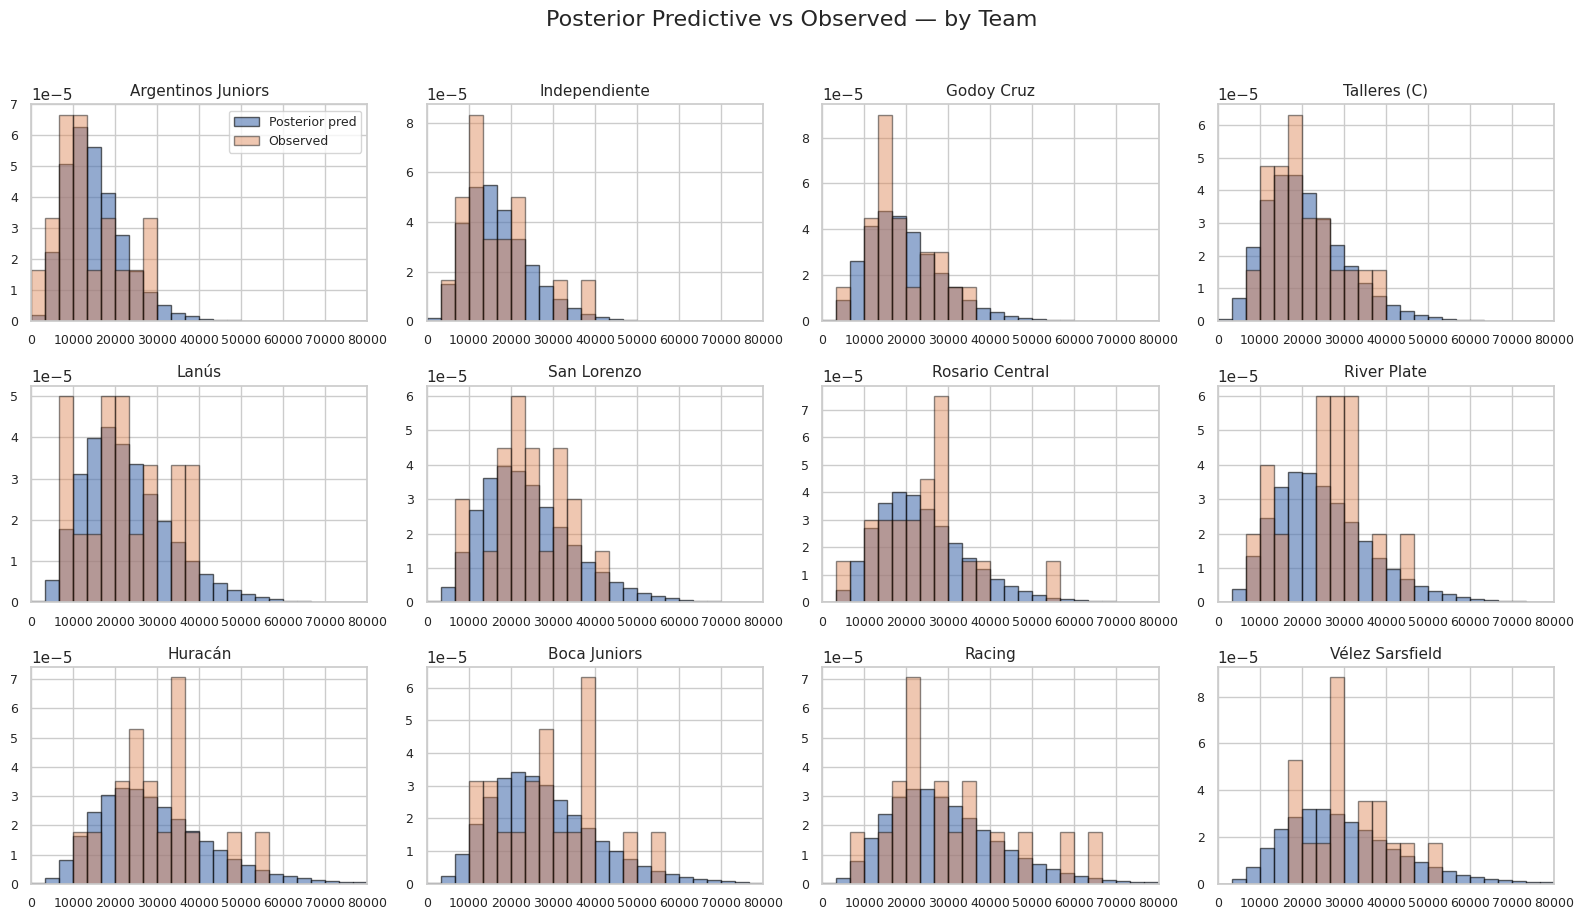

In [49]:
# Posterior predictive draws for team panels
with hierarchical_model:
    ppc_team = pm.sample_posterior_predictive(idata_h, random_seed=42, extend_inferencedata=True)

y_pred = ppc_team.posterior_predictive["y"].values
y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])

team_order = (df_obs.groupby("team")["attendance"].median().sort_values().index)

bins = np.linspace(0, 80000, 25)
n_teams = len(team_order)
n_cols = 4
n_rows = int(np.ceil(n_teams / n_cols))

plt.figure(figsize=(4*n_cols, 3*n_rows))
sns.set_theme(style="whitegrid")

for i, team in enumerate(team_order):
    ax = plt.subplot(n_rows, n_cols, i+1)

    mask_team = (df_obs["team"] == team).to_numpy()
    y_obs_team = attendance_obs[mask_team]
    y_pred_team = y_pred_flat[:, mask_team].reshape(-1)

    ax.hist(y_pred_team, bins=bins, density=True, alpha=0.6, edgecolor="black", label="Posterior pred")
    ax.hist(y_obs_team, bins=bins, density=True, alpha=0.45, edgecolor="black", label="Observed")

    ax.set_title(str(team), fontsize=11)
    ax.set_xlim(0, 80000)
    ax.tick_params(axis="both", labelsize=9)

    if i == 0:
        ax.legend(fontsize=9)

plt.suptitle("Posterior Predictive vs Observed — by Team", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Output()

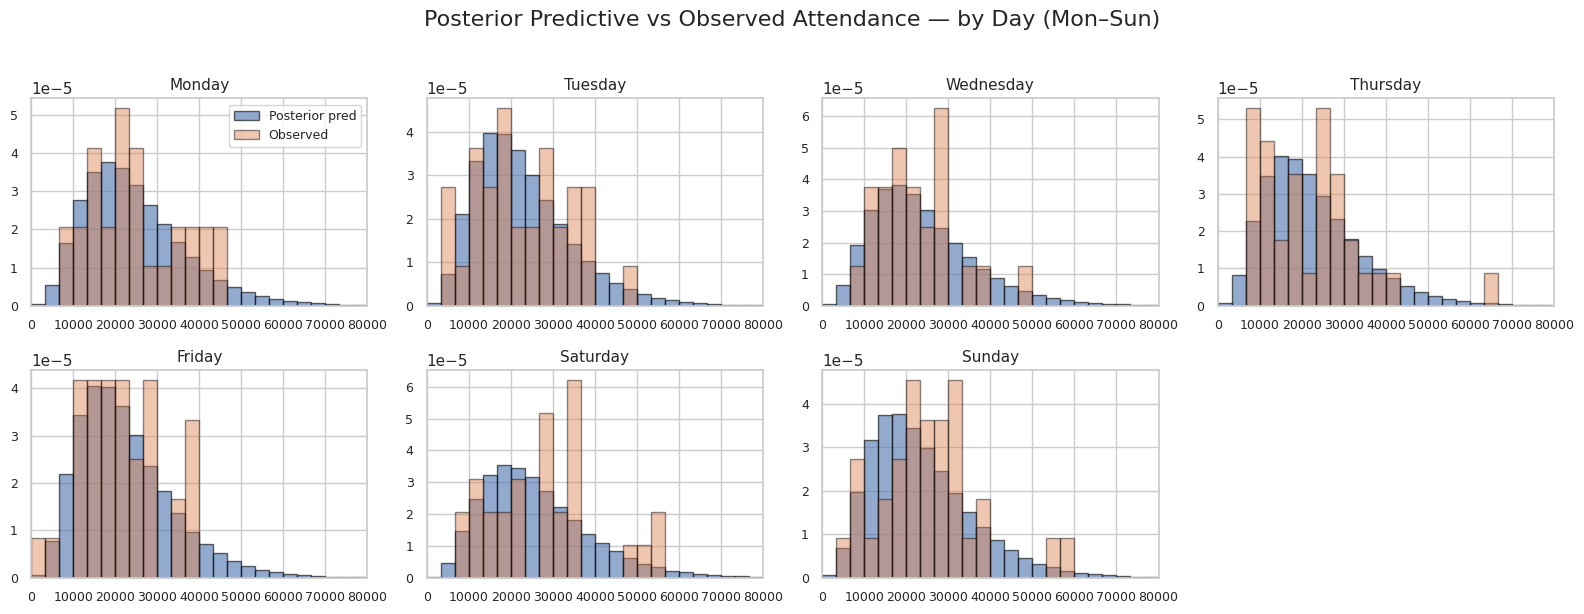

In [54]:
# POSTERIOR PREDICTIVE BY DAY (ordered Mon..Sun)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

# Posterior predictive draws
with hierarchical_model:
    ppc_day = pm.sample_posterior_predictive(idata_h, random_seed=42, extend_inferencedata=True)

y_pred = ppc_day.posterior_predictive["y"].values
y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])

attendance_obs = df_obs["attendance"].to_numpy()

# Use fixed weekday order
day_order_plot = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Keep only days that actually appear in df_obs (safe)
day_order_plot = [d for d in day_order_plot if d in df_obs["day"].unique()]

bins = np.linspace(0, 80000, 25)
n_days = len(day_order_plot)
n_cols = 4
n_rows = int(np.ceil(n_days / n_cols))

plt.figure(figsize=(4*n_cols, 3*n_rows))
sns.set_theme(style="whitegrid")

for i, day in enumerate(day_order_plot):
    ax = plt.subplot(n_rows, n_cols, i+1)

    mask_day = (df_obs["day"] == day).to_numpy()
    y_obs_day = attendance_obs[mask_day]
    y_pred_day = y_pred_flat[:, mask_day].reshape(-1)

    ax.hist(y_pred_day, bins=bins, density=True, alpha=0.6, edgecolor="black", label="Posterior pred")
    ax.hist(y_obs_day, bins=bins, density=True, alpha=0.45, edgecolor="black", label="Observed")

    ax.set_title(day, fontsize=11)
    ax.set_xlim(0, 80000)
    ax.tick_params(axis="both", labelsize=9)

    if i == 0:
        ax.legend(fontsize=9)

plt.suptitle("Posterior Predictive vs Observed Attendance — by Day (Mon–Sun)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


Posterior Summary (hierarchical):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,10.043,0.086,9.887,10.211,0.002,0.001,2198.0,3543.0,1.0
sigma_team,0.267,0.078,0.135,0.405,0.002,0.002,2169.0,3036.0,1.0
sigma_day,0.054,0.044,0.000,0.130,0.001,0.001,3228.0,3211.0,1.0
alpha_disp,4.990,0.481,4.070,5.867,0.006,0.005,6923.0,5064.0,1.0


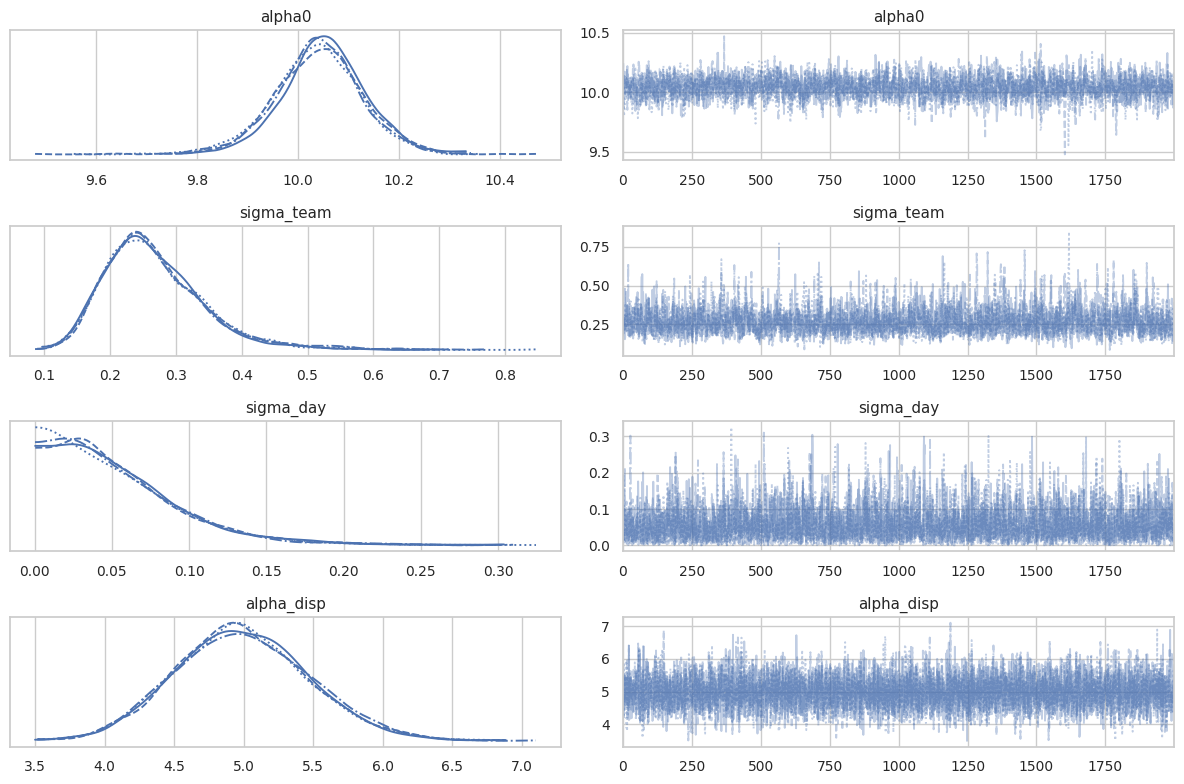

Output()

<Figure size 1000x600 with 0 Axes>

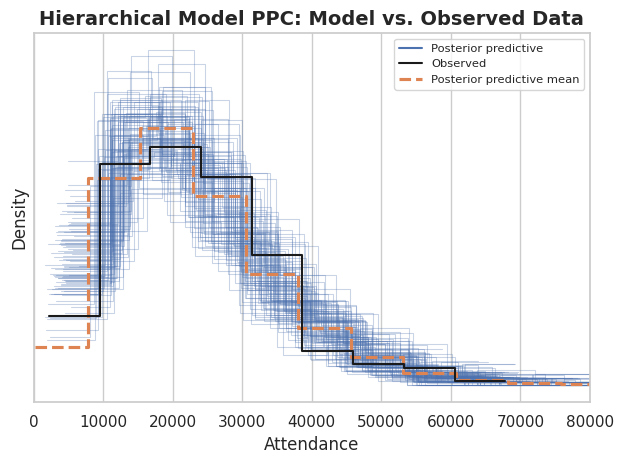

In [50]:
# Posterior summary and diagnostics for hierarchical model

print("Posterior Summary (hierarchical):")
display(az.summary(idata_h, var_names=["alpha0", "sigma_team", "sigma_day", "alpha_disp"]))

# Trace plots for convergence check
az.plot_trace(idata_h, var_names=["alpha0", "sigma_team", "sigma_day", "alpha_disp"])
plt.tight_layout()
plt.show()

# Posterior predictive check
with hierarchical_model:
    ppc_h = pm.sample_posterior_predictive(idata_h, random_seed=123, extend_inferencedata=True)

plt.figure(figsize=(10, 6))
az.plot_ppc(ppc_h, num_pp_samples=100, alpha=0.3)
plt.title("Hierarchical Model PPC: Model vs. Observed Data", fontsize=14, weight="bold")
plt.xlabel("Attendance")
plt.ylabel("Density")
plt.xlim(0, 80000)
plt.tight_layout()
plt.show()


# **4. Model Comparison**


=== Model comparison table (PSIS-LOO) ===


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-2316.686817,12.477309,0.000000,0.998638,10.303178,0.000000,False,log
complete_pooling,1,-2335.090771,2.036030,18.403955,0.001362,10.459730,5.722686,False,log


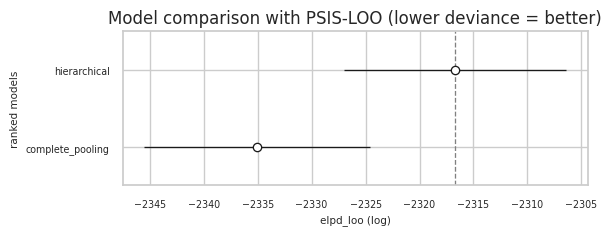

In [51]:
# Compare models with PSIS-LOO
cmp = az.compare({"complete_pooling": idata_cp, "hierarchical": idata_h}, ic="loo", scale="log")

print("\n=== Model comparison table (PSIS-LOO) ===")
display(cmp)

az.plot_compare(cmp)
plt.title("Model comparison with PSIS-LOO (lower deviance = better)")
plt.show()


# **5. Predictions and Interpretation**

In [52]:
print("Preparing Full Data for Imputation...")

df_full = pd.read_csv("sports-attendance-data.csv")
df_full["day"] = pd.Categorical(df_full["day"], categories=day_order, ordered=True)

df_full["team_idx"] = df_full["team"].astype("category").cat.codes
df_full["day_idx"]  = df_full["day"].astype("category").cat.codes

attendance_all = df_full["attendance"].to_numpy()
team_idx_all   = df_full["team_idx"].to_numpy()
day_idx_all    = df_full["day_idx"].to_numpy()

team_names_full = df_full["team"].astype("category").cat.categories
day_names_full  = df_full["day"].astype("category").cat.categories

missing_mask = np.isnan(attendance_all)
missing_rows = np.where(missing_mask)[0]

coords_full = {"team": team_names_full, "day": day_names_full, "game": np.arange(len(df_full))}

with pm.Model(coords=coords_full) as hierarchical_model_full:

    team_idx_data = pm.Data("team_idx", team_idx_all, dims="game")
    day_idx_data  = pm.Data("day_idx",  day_idx_all, dims="game")

    # Priors match your hierarchical model
    alpha0 = pm.Normal("alpha0", mu=np.log(20000), sigma=1.0)

    sigma_team = pm.Exponential("sigma_team", lam=1.0)
    beta_team_raw = pm.Normal("beta_team_raw", mu=0, sigma=1, dims="team")
    beta_team = pm.Deterministic("beta_team", beta_team_raw * sigma_team, dims="team")

    sigma_day = pm.Exponential("sigma_day", lam=1.0)
    gamma_day_raw = pm.Normal("gamma_day_raw", mu=0, sigma=1, dims="day")
    gamma_day = pm.Deterministic("gamma_day", gamma_day_raw * sigma_day, dims="day")

    log_mu_ij = alpha0 + beta_team[team_idx_data] + gamma_day[day_idx_data]
    mu_ij = pm.Deterministic("mu_ij", pm.math.exp(log_mu_ij), dims="game")

    alpha_disp = pm.Exponential("alpha_disp", lam=1/10)

    # Likelihood with NaNs for imputation
    y = pm.NegativeBinomial("y", mu=mu_ij, alpha=alpha_disp, observed=attendance_all, dims="game")

    print("Sampling Imputation Model...")
    idata_full = pm.sample(draws=2000, tune=2000, chains=4, target_accept=0.95, random_seed=42)

# Extract imputed values
y_miss = idata_full.posterior["y_unobserved"].values
y_miss_flat = y_miss.reshape(-1, y_miss.shape[-1])

pred_mean = y_miss_flat.mean(axis=0)
pred_hdi  = az.hdi(y_miss_flat, hdi_prob=0.94)

df_full.loc[missing_rows, "Predicted_Attendance"] = pred_mean.round().astype(int)
df_full.loc[missing_rows, "HDI_Lower"] = pred_hdi[:, 0].round().astype(int)
df_full.loc[missing_rows, "HDI_Upper"] = pred_hdi[:, 1].round().astype(int)

pred_table = df_full.loc[missing_rows,["team", "day", "Predicted_Attendance", "HDI_Lower", "HDI_Upper"]]

print("Final Report: Predicted Attendance for Missing Games")
display(pred_table)


Preparing Full Data for Imputation...
Sampling Imputation Model...


/usr/local/lib/python3.12/dist-packages/pymc/model/core.py:1305: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/usr/local/lib/python3.12/dist-packages/pymc/model/core.py:1319: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Output()


=== Final Report: Predicted Attendance for Missing Games ===


/tmp/ipython-input-830929542.py:68: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi  = az.hdi(y_miss_flat, hdi_prob=0.94)


,team,day,Predicted_Attendance,HDI_Lower,HDI_Upper
2,River Plate,Thursday,24321.0,7271.0,46475.0
7,River Plate,Tuesday,25144.0,6365.0,47469.0
10,River Plate,Friday,24901.0,5170.0,45249.0
14,River Plate,Monday,25726.0,5042.0,46467.0
17,River Plate,Tuesday,25315.0,6325.0,46805.0
29,Boca Juniors,Wednesday,27498.0,6674.0,49658.0
48,Racing,Tuesday,29218.0,7200.0,53185.0
51,Racing,Sunday,30034.0,7026.0,54071.0
58,Racing,Tuesday,29183.0,7156.0,54773.0
64,Independiente,Tuesday,17237.0,4502.0,32651.0


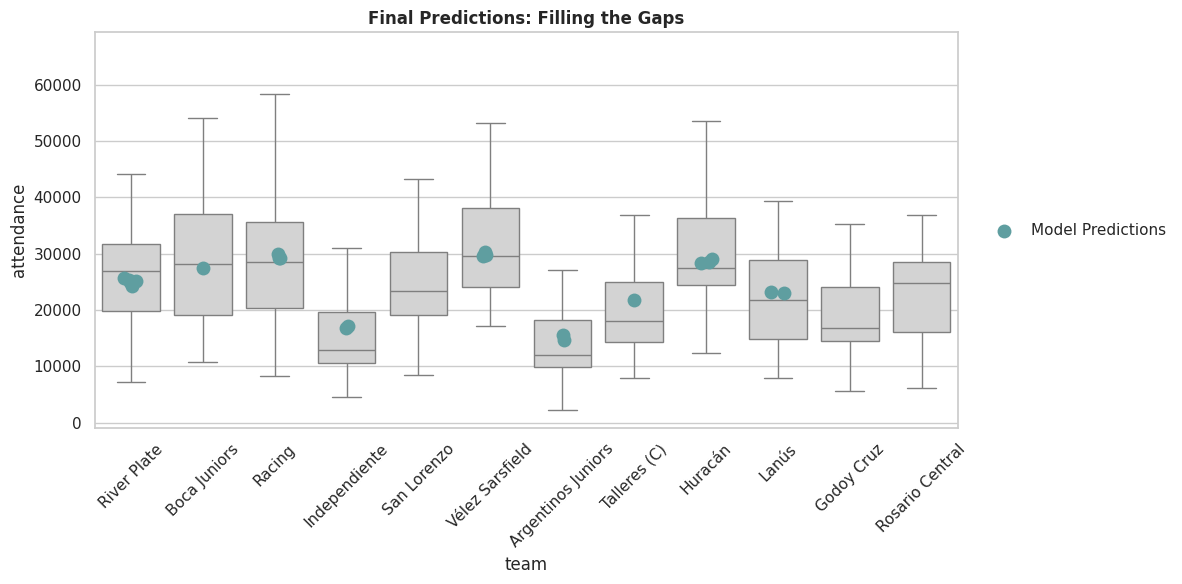

In [111]:
plt.figure(figsize=(12, 6))

ax = sns.boxplot(data=df_full.dropna(subset=['attendance']), x='team', y='attendance', color='lightgrey',fliersize=0)

sns.stripplot(data=df_full.loc[missing_rows], x='team', y='Predicted_Attendance', color='cadetblue', marker='o', s=10, label='Model Predictions',ax=ax)

plt.title("Final Predictions: Filling the Gaps", weight='bold')
plt.xticks(rotation=45)

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))

#legend outside the plot
ax.legend(unique.values(), unique.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout()
plt.show()

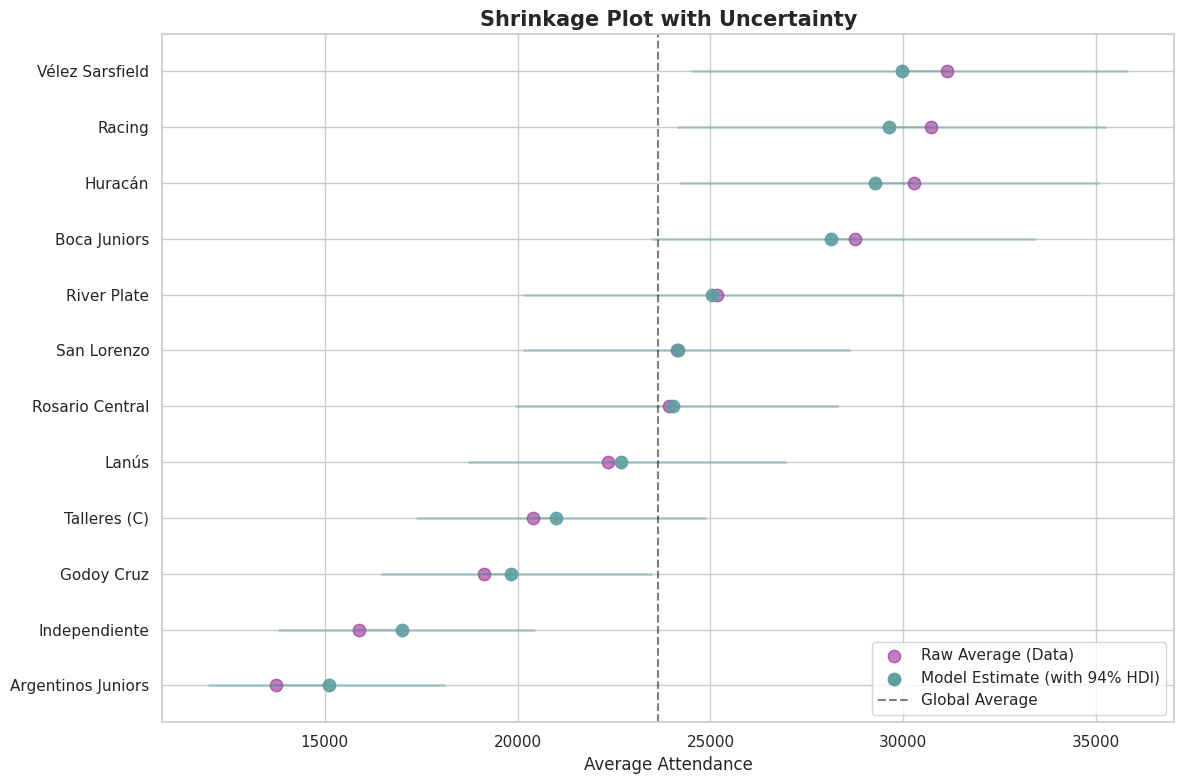

In [103]:
#Calculate raw means (Blue Dots)
raw_means = df_obs.groupby("team")["attendance"].mean()

#Calculare model estimates and HDIs (Red Dots + Lines)
# We need the full posterior samples of mu_ij (not just the mean)
# Shape: (chains, draws, n_games)
mu_samples = idata_h.posterior["mu_ij"].stack(sample=("chain", "draw")).values
# Shape becomes: (n_games, n_samples)
mu_samples = mu_samples.T # Shape: (n_samples, n_games)

model_means = {}
model_hdis = {}

# For each team, calculate the posterior distribution of their "Average Attendance"
for team in team_names:
    # Find games played by this team
    team_games_mask = (df_obs["team"] == team).values

    if np.sum(team_games_mask) > 0:
        # Get all predictions for this team's games
        team_mu_samples = mu_samples[:, team_games_mask]

        # Average across the games for each posterior draw
        # This gives us a distribution of "Average Attendance" for the team
        team_avg_dist = team_mu_samples.mean(axis=1)

        # Store Mean and HDI
        model_means[team] = np.mean(team_avg_dist)
        model_hdis[team] = az.hdi(team_avg_dist, hdi_prob=0.94)

# Convert to Series for easy plotting
model_means_series = pd.Series(model_means)


plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Sort teams by Raw Size
sorted_teams = raw_means.sort_values().index
y_range = range(len(sorted_teams))

#Draw Arrows (Shrinkage)
for i, team in enumerate(sorted_teams):
    raw = raw_means[team]
    mod = model_means_series[team]
    plt.arrow(raw, i, mod - raw, 0, color="gray", alpha=0.3, length_includes_head=True, head_width=0.2)

#Plot Raw Means (Blue)
plt.scatter(raw_means[sorted_teams], y_range, color="purple", alpha=0.5, label="Raw Average (Data)", s=80)

#Plot Model Estimates with Error Bars (Red)
# We iterate to plot error bars individually
for i, team in enumerate(sorted_teams):
    mean = model_means_series[team]
    hdi = model_hdis[team]

    # Draw the Error Bar (HDI)
    plt.hlines(i, hdi[0], hdi[1], color="cadetblue", alpha=0.4, linewidth=2)

    # Draw the Point Estimate
    plt.scatter(mean, i, color="cadetblue", alpha=0.9, s=80)

# Add dummy scatter for legend
plt.scatter([], [], color="cadetblue", label="Model Estimate (with 94% HDI)", s=80)

# D. Global Average Line
global_mean = df_obs["attendance"].mean()
plt.axvline(global_mean, color='black', linestyle='--', alpha=0.5, label="Global Average")

# Formatting
plt.yticks(y_range, sorted_teams)
plt.xlabel("Average Attendance")
plt.title("Shrinkage Plot with Uncertainty", fontsize=15, weight='bold')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1445260848.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_means_day = df_obs.groupby("day")["attendance"].mean()


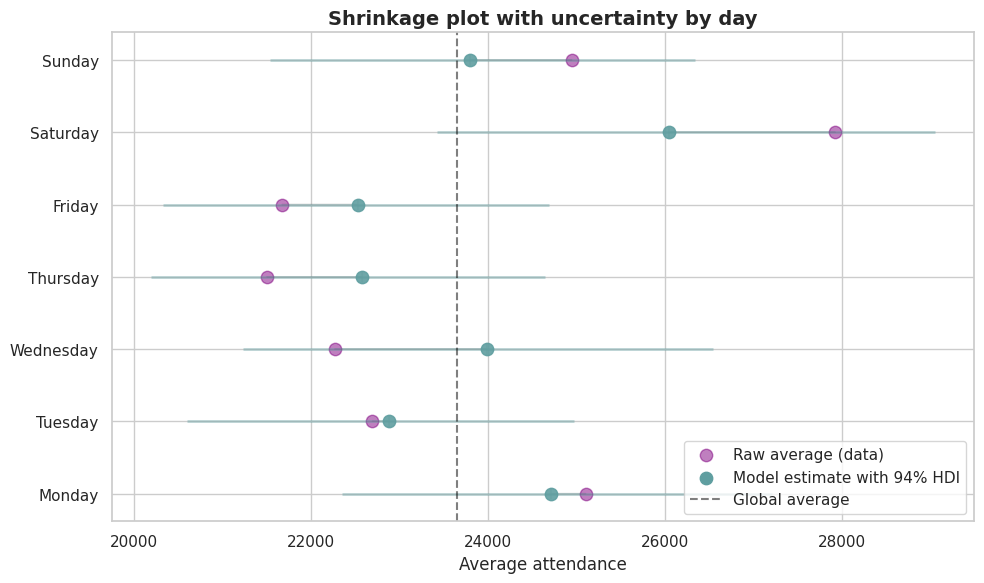

In [112]:
#Shrinkage plot for days (raw means vs model with HDI)

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_obs["day"] = pd.Categorical(df_obs["day"], categories=day_order, ordered=True)

# --- 1. RAW MEANS BY DAY (purple dots) ---
raw_means_day = df_obs.groupby("day")["attendance"].mean()

# --- 2. MODEL ESTIMATES + HDIs BY DAY (cadetblue dots + lines) ---
# Posterior samples for mu_ij
mu_samples = idata_h.posterior["mu_ij"].stack(sample=("chain", "draw")).values
mu_samples = mu_samples.T  # (n_samples, n_games)

model_means_day = {}
model_hdis_day = {}

for day in day_order:
    day_mask = (df_obs["day"] == day).values
    if np.sum(day_mask) > 0:
        day_mu_samples = mu_samples[:, day_mask]
        day_avg_dist = day_mu_samples.mean(axis=1)

        model_means_day[day] = day_avg_dist.mean()
        model_hdis_day[day] = az.hdi(day_avg_dist, hdi_prob=0.94)

model_means_day = pd.Series(model_means_day)

# --- 3. PLOT ---
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Keep only days that appear in data, in Mon..Sun order
sorted_days = [d for d in day_order if d in raw_means_day.index]
y_range = range(len(sorted_days))

# A. Arrows raw -> model
for i, day in enumerate(sorted_days):
    raw = raw_means_day[day]
    mod = model_means_day[day]
    plt.arrow(raw, i, mod - raw, 0, color="gray", alpha=0.3, length_includes_head=True, head_width=0.15)

# B. Raw means
plt.scatter(raw_means_day[sorted_days], y_range, color="purple", alpha=0.5, label="Raw average (data)", s=80)

# C. Model means + HDI
for i, day in enumerate(sorted_days):
    mean = model_means_day[day]
    hdi = model_hdis_day[day]

    plt.hlines(i, hdi[0], hdi[1], color="cadetblue", alpha=0.4, linewidth=2)
    plt.scatter(mean, i, color="cadetblue", alpha=0.9, s=80)

plt.scatter([], [], color="cadetblue", label="Model estimate with 94% HDI", s=80)

# D. Global average line
global_mean = df_obs["attendance"].mean()
plt.axvline(global_mean, color="black", linestyle="--", alpha=0.5, label="Global average")

# Labels
plt.yticks(y_range, sorted_days)
plt.xlabel("Average attendance")
plt.title("Shrinkage plot with uncertainty by day", fontsize=14, weight="bold")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
